In [1]:
%load_ext autoreload
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display
from glob import glob
import pickle
from tqdm import tqdm
from data_util import Episode, load_episode
from metric_utils import metrics, decision_square
import os
from collections import defaultdict

In [3]:
files = glob('data/*region_5*.pkl')
runs = []
load_venv = False
for f in files:
    try:
        runs.append(load_episode(f, load_venv=load_venv))
    except (AssertionError, KeyError) as e:
        print(f"Malformed file {f}: {e}")
        #os.remove(f)

len(runs)

1885

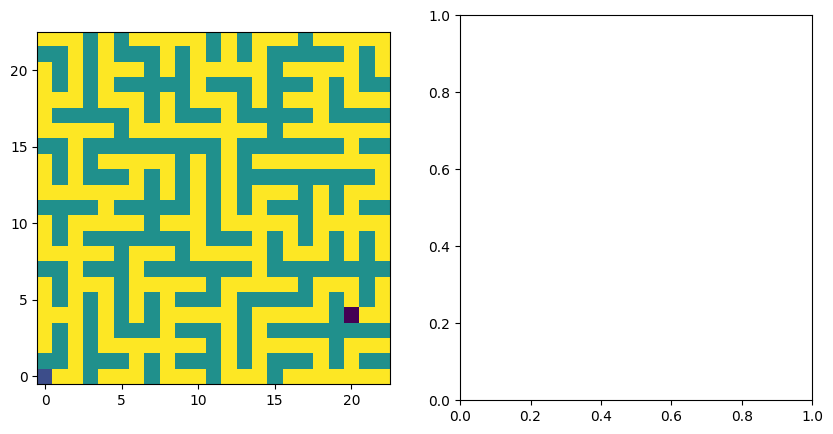

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
R = 3
ax[0].imshow(runs[R].grid(), origin='lower')
if load_venv: ax[1].imshow(runs[R]["start_info"]["rgb"])
plt.show()

## Graph metrics on all grids

In [5]:
def mouse_adjacent_to_cheese(g: np.ndarray) -> bool:
    # evil
    return (np.abs(np.array(maze.get_mouse_pos(g)) - np.array(maze.get_cheese_pos(g))).sum() == 1.).all()

In [6]:
recorded_metrics = defaultdict(list)
got_cheese = []
for run in tqdm(runs):
    g = run.grid()
    if decision_square(g) is None or (g[-5:, -5:] == maze.CHEESE).any():
        continue
    for name, metric in metrics.items():
        recorded_metrics[name].append(metric(g))
    got_cheese.append(float(mouse_adjacent_to_cheese(run.grid(t=-1))))

got_cheese = np.array(got_cheese)
len(got_cheese)

100%|██████████| 1885/1885 [00:21<00:00, 89.16it/s] 


997

In [7]:
for name, metric in recorded_metrics.items():
    recorded_metrics[name] = np.array(metric)

In [8]:
prob = sum(got_cheese) / len(got_cheese)
print(f'P(get cheese | decision square, cheese not in top 5x5) = {prob}')

P(get cheese | decision square, cheese not in top 5x5) = 0.5827482447342026


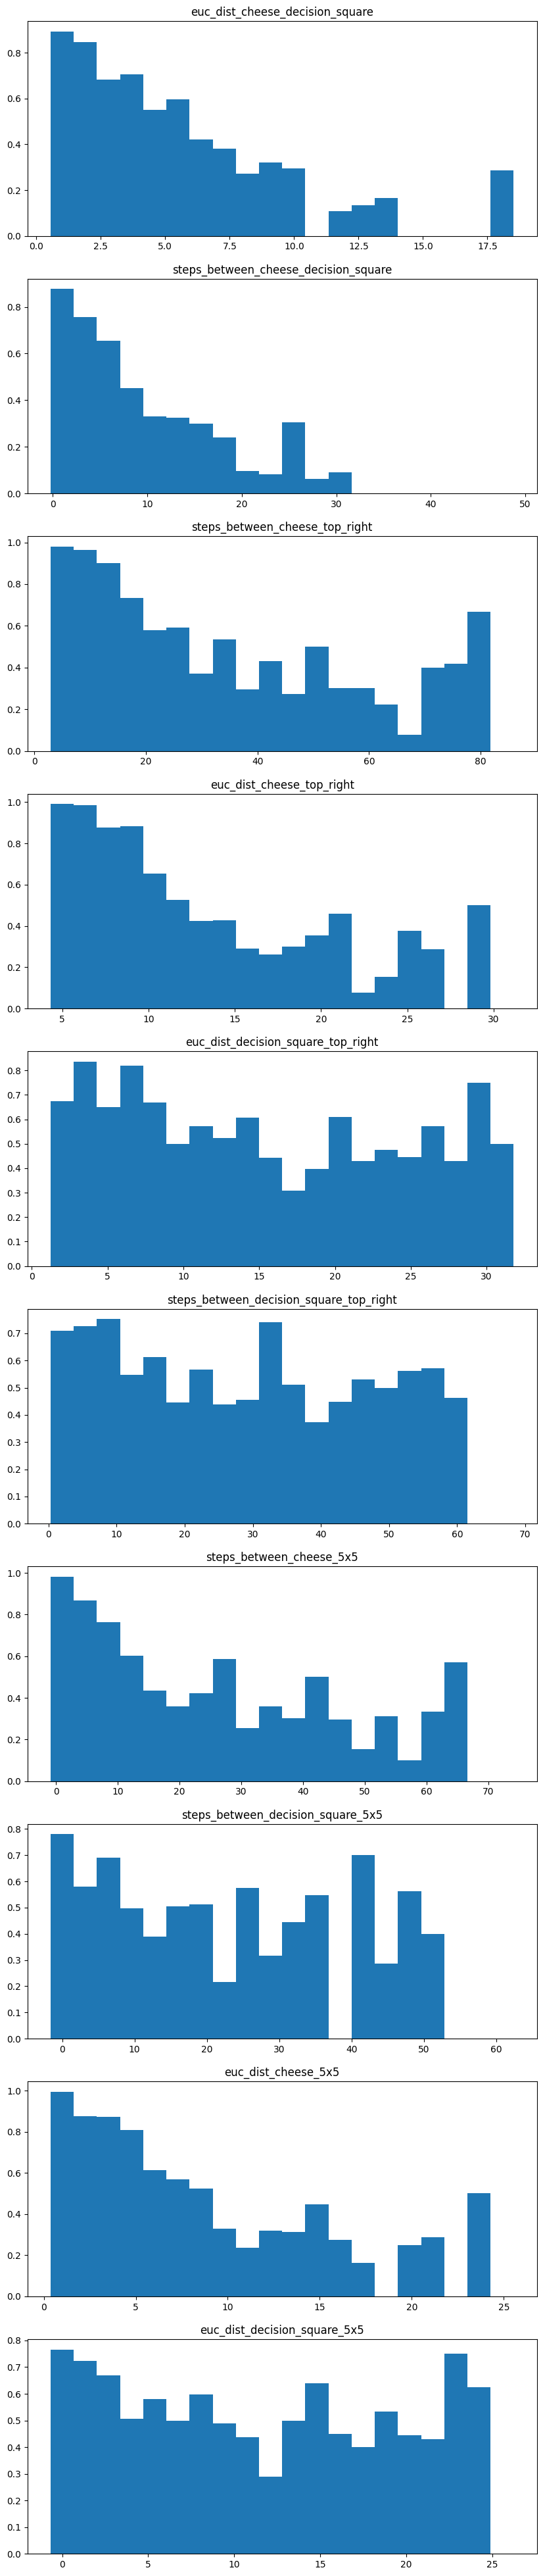

In [9]:
# Use matplotlib to plot all recorded_metrics by name (key) vertically in a single figure
fig, ax = plt.subplots(len(recorded_metrics), 1, figsize=(10, 5*len(recorded_metrics)))
for i, (name, values) in enumerate(recorded_metrics.items()):
    bins, edges = np.histogram(values, bins=20)
    percentages = []
    for j, (b, edge) in enumerate(zip(bins, edges)):
         num_runs_in_this_bin = b
         # TODO: More principled then adding one to num_runs_in_bin
         percentages.append(sum(got_cheese[np.logical_and(values >= edges[j], values < edges[j+1])]) / (num_runs_in_this_bin+1)) 
    ax[i].bar(edges[:-1], percentages, width=edges[1]-edges[0])
    ax[i].set_title(name)
  
plt.show()

## Replay a run

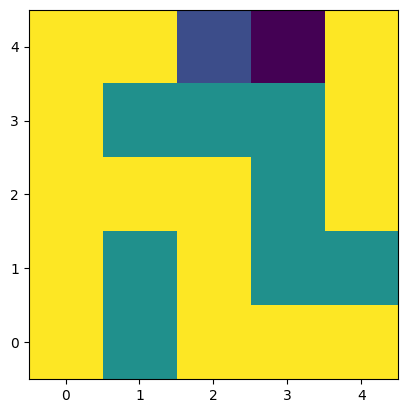

In [10]:
r = runs[0]
for t in range(0, r.steps):
    grid = r.grid(t)
    plt.imshow(grid, origin='lower')
    display.display(plt.gcf())
    display.clear_output(wait=True)